## 1. Data Reading

In [56]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch

In [57]:
device = torch.device("cuda")
device

device(type='cuda')

In [58]:
def findFiles(path): return glob.glob(path)

print(findFiles('f:/Master degree/Advanced deep networks/DataSet/names/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-" #All upper and lower characters and some punctiations are added in all_letters.
                                              #Last character(-) will use as a padding char.
n_letters = len(all_letters)    #number of total letters

['f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Arabic.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Chinese.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Czech.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Dutch.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\English.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\French.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\German.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Greek.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Irish.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Italian.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Japanese.txt', 'f:/Master degree/Advanced deep networks/DataSet/names/data/names\\Korean.txt', 'f:/Master degree/Advanced deep networ

In [59]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s): # It converts some stranger characters to most similar latin letters.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))  #For example in this name: Ś --> S



Slusarski


In [60]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('f:/Master degree/Advanced deep networks/DataSet/names/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories) #number of languages

In [61]:
print(n_categories)

18


## 2. Preprocessing

In [62]:
#Returns an index number as location of any letter in all_letters | Example: letter2index('a') -> 0
def letter2index(letter):
    letter = unicodeToAscii(letter)
    return all_letters.find(letter)

In [63]:
#Returns an one-hot encoding tensor letter index is 1 and others are 0.(tensor size: 1,n_letters)
def letter2tensor(letter):
    idx = letter2index(letter)
    torch_vec = torch.zeros(n_letters)
    torch_vec[idx] = 1
    return torch_vec

In [64]:
#Returns a tensor which include one-hot-encoded letter tensors inside.(tensor size: 1,name_length,n_letters)
def name2tensor(name):
    name_letter_tensor = torch.zeros(1,len(name),n_letters)
    for idx,letter in enumerate(name):
        name_letter_tensor[0][idx][letter2index(letter)] = 1
    return name_letter_tensor

In [65]:
name2tensor('Ali').size()

torch.Size([1, 3, 58])

In [66]:
#Assign a number to each language category
def category_encoder(categories):
    category_dict = {x:idx for idx,x in enumerate(categories)}
    return category_dict

In [67]:
category_dict = category_encoder(category_lines.keys())
category_dict

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

In [68]:
#Return total counts of each language category
def get_category_counts(category_dict):
    category_count_dict = {category:len(category_lines[category]) for category in category_dict.keys()}
    return category_count_dict

In [69]:
#Total counts of languages
category_counts_dict = get_category_counts(category_dict)
category_counts_dict

{'Arabic': 2000,
 'Chinese': 268,
 'Czech': 519,
 'Dutch': 297,
 'English': 3668,
 'French': 277,
 'German': 724,
 'Greek': 203,
 'Irish': 232,
 'Italian': 709,
 'Japanese': 991,
 'Korean': 94,
 'Polish': 139,
 'Portuguese': 74,
 'Russian': 9408,
 'Scottish': 100,
 'Spanish': 298,
 'Vietnamese': 73}

In [70]:
#Sort total counts for each category and assign a dict
category_counts_sorted = dict(sorted(category_counts_dict.items(), key=lambda x: x[1],reverse=True))

<BarContainer object of 18 artists>

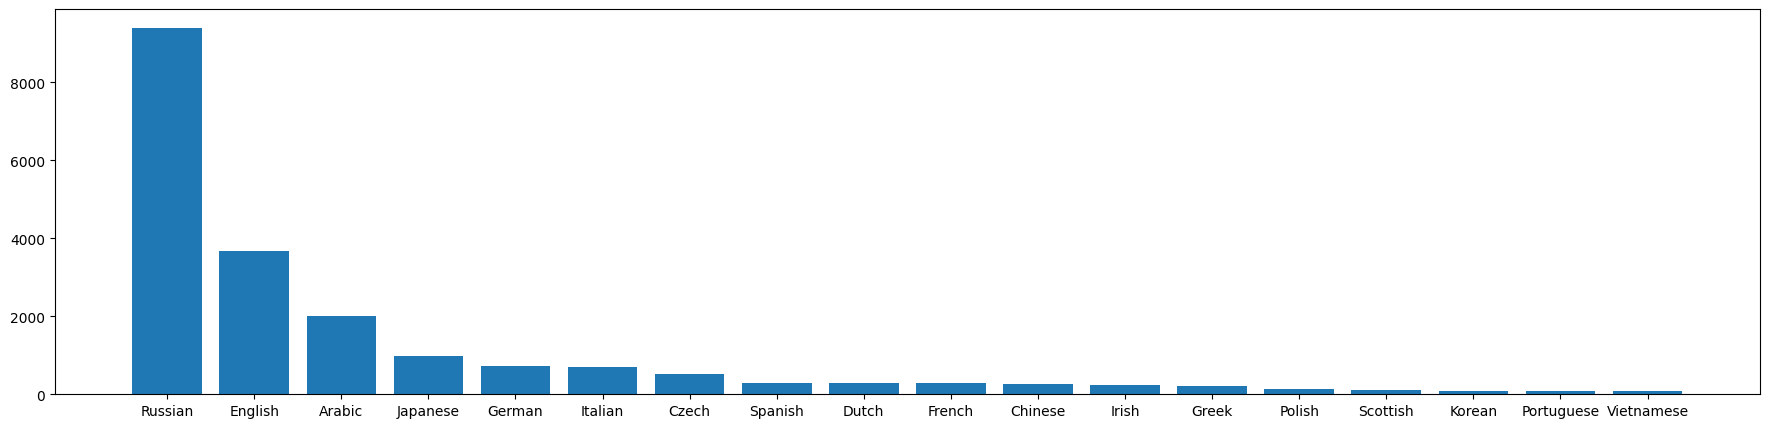

In [71]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(22,5))
plt.bar(category_counts_sorted.keys(),category_counts_sorted.values())

In [72]:
#get the longest name in all names from all categories
flatten_name_list = sum([name for name in category_lines.values()],[])
max_name_size = sorted([len(name) for name in flatten_name_list])[-1]
max_name_size

20

Longest name has 20 char inside.

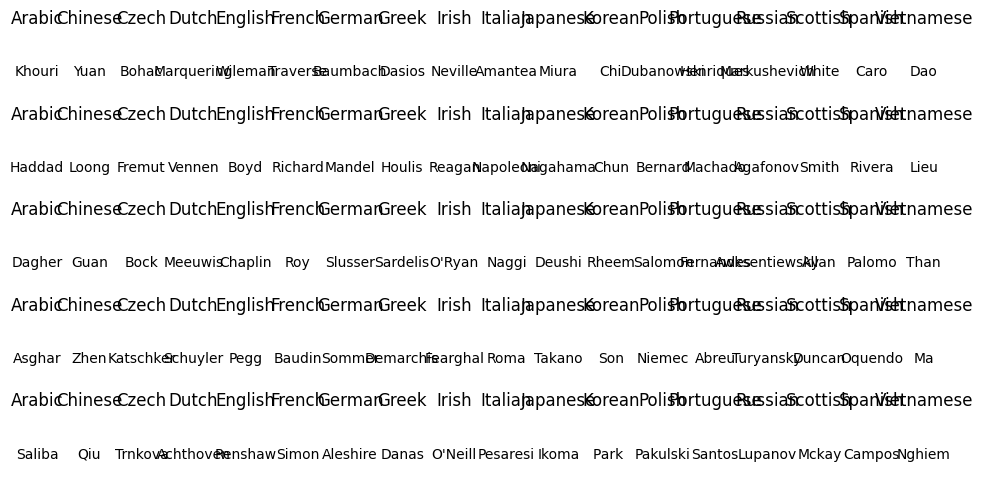

In [73]:
import matplotlib.pyplot as plt
import random

# Number of samples you want to draw from each category
num_samples_per_category = 5

# Plot settings
plt.figure(figsize=(12, 6))

# For each category
for category in all_categories:
    # Select a few random samples
    samples = random.sample(category_lines[category], num_samples_per_category)

    # Plot each sample
    for i, sample in enumerate(samples):
        plt.subplot(num_samples_per_category, len(all_categories), i * len(all_categories) + all_categories.index(category) + 1)
        plt.axis('off')
        plt.title(category)
        plt.text(0.5, 0.5, sample, ha='center', va='center')

plt.show()


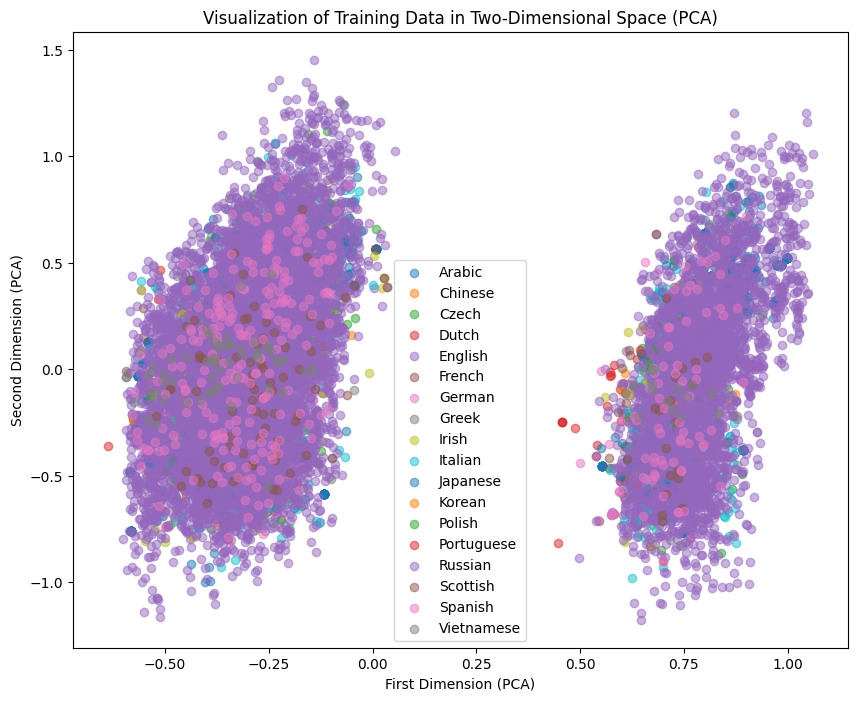

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # Import the PCA module from scikit-learn

# Number of dimensions for data visualization
num_dimensions = 2

# Convert all feature vectors to a constant length
max_length = max(len(name2tensor(name).view(-1)) for category in category_lines for name in category_lines[category])
all_data = []
all_labels = []

for category, names in category_lines.items():
    for name in names:
        name_tensor = name2tensor(name)
        name_data = name_tensor.view(-1).numpy()
        # Padding the feature vector to match the length of the longest vector
        if len(name_data) < max_length:
            name_data = np.pad(name_data, (0, max_length - len(name_data)))
        all_data.append(name_data)
        all_labels.append(category)

# Applying PCA to the data
pca = PCA(n_components=num_dimensions)
data_2d = pca.fit_transform(all_data)

# Plot settings
plt.figure(figsize=(10, 8))

# For each category
for category in all_categories:
    indices = [i for i, label in enumerate(all_labels) if label == category]
    plt.scatter(data_2d[indices, 0], data_2d[indices, 1], label=category, alpha=0.5)

plt.legend()
plt.xlabel('First Dimension (PCA)')
plt.ylabel('Second Dimension (PCA)')
plt.title('Visualization of Training Data in Two-Dimensional Space (PCA)')

plt.show()


## 3. Dataset Creating

In [75]:
total_name_size = sum(category_counts_sorted.values()) # total name number: 20050
X_tensor = [] #Include all one-hot-encoded name tensors
y_tensor = [] #Include all name category numb tensors (target)
for category in category_lines.keys():
    for idx,name in enumerate(category_lines[category]): #This loop is used for make names a fixed size for fixed hidden layer sizes in nn.
        name = name + '-'*(20 - len(name)) # padding char is selected as '-'.
        X_tensor.append(name2tensor(name))
        y_tensor.append(torch.tensor(category_dict[category]).view(1,))
len(X_tensor)

20074

In [77]:
X_tensor_reshaped = torch.cat(X_tensor, dim=0) #list to tensor
X_tensor_reshaped.size()

torch.Size([20074, 20, 58])

In [78]:
y_tensor_reshaped = torch.cat(y_tensor,dim=0) #list to tensor
y_tensor_reshaped.size()

torch.Size([20074])

In [79]:
#Feature and target tensors are splited as train and test set as rate %10.
from sklearn.model_selection import train_test_split
X_train, X_test , y_train ,y_test = train_test_split(X_tensor_reshaped.numpy(),
                                                     y_tensor_reshaped.numpy(),
                                                     test_size=0.1,
                                                     random_state=42,
                                                     stratify=y_tensor_reshaped.numpy())

In [80]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((18066, 20, 58), (2008, 20, 58), (18066,), (2008,))

In [81]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [83]:
#Train and test samples are splited as batch_size for preparing to training and testing.
def train_test_loader(X_train,y_train,X_test,y_test,batch_size):
    train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size,drop_last=True)

    valid_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size,drop_last=True)
    return train_loader,valid_loader

## 4. Model Creating

In [100]:
#This is global variable for embedding layer size for all models.
EMBED_SIZE = 10

In [85]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        combined1 = torch.cat((input,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

In [86]:
class RNN_Embed(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Embed, self).__init__()
        self.hidden_size = hidden_size
        #self.vocab_size = vocab_size
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        x_argmax = torch.argmax(input,dim=0)
        embeds = self.embed(x_argmax)
        combined1 = torch.cat((embeds,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

In [87]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 10
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [88]:
def accuracy_2(pred,label): #Return how much true label match with predictions(max prob. class index)
    return torch.sum(torch.argmax(pred,dim=1) == label).item()

## 5. Training and Evaluation

In [89]:
def rnn_train_test_process(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [90]:
rnn_dict = rnn_train_test_process(has_embedding=False)
rnn_dict


Epoch no: 1 | Train_loss: 1.97495 | Val_loss: 1.84161 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 5158.23102 | Val_loss: 2.45302 | Val_Accuracy: 0.47
Epoch no: 3 | Train_loss: 2.45368 | Val_loss: 2.25503 | Val_Accuracy: 0.47
Epoch no: 4 | Train_loss: 2.14544 | Val_loss: 2.06026 | Val_Accuracy: 0.47
Epoch no: 5 | Train_loss: 2.00653 | Val_loss: 1.96346 | Val_Accuracy: 0.47
Epoch no: 6 | Train_loss: 1.93555 | Val_loss: 1.91256 | Val_Accuracy: 0.47
Epoch no: 7 | Train_loss: 1.89788 | Val_loss: 1.88495 | Val_Accuracy: 0.47
Epoch no: 8 | Train_loss: 1.87725 | Val_loss: 1.86935 | Val_Accuracy: 0.47
Epoch no: 9 | Train_loss: 1.86546 | Val_loss: 1.86007 | Val_Accuracy: 0.47
Epoch no: 10 | Train_loss: 1.85836 | Val_loss: 1.85425 | Val_Accuracy: 0.47
Best accuracy is : %46.770833333333336 for batch_size =128


{128: 0.46770833333333334}

In [91]:
rnn_dict_embed = rnn_train_test_process(has_embedding=True)
rnn_dict_embed


Epoch no: 1 | Train_loss: 1.8782 | Val_loss: 1.77841 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.64961 | Val_loss: 1.56386 | Val_Accuracy: 0.54
Epoch no: 3 | Train_loss: 1.55078 | Val_loss: 1.52309 | Val_Accuracy: 0.55
Epoch no: 4 | Train_loss: 1.51671 | Val_loss: 1.49502 | Val_Accuracy: 0.56
Epoch no: 5 | Train_loss: 1.50183 | Val_loss: 1.47415 | Val_Accuracy: 0.56
Epoch no: 6 | Train_loss: 1.47219 | Val_loss: 1.44694 | Val_Accuracy: 0.56
Epoch no: 7 | Train_loss: 1.47546 | Val_loss: 1.47753 | Val_Accuracy: 0.56
Epoch no: 8 | Train_loss: 1.45533 | Val_loss: 1.40858 | Val_Accuracy: 0.57
Epoch no: 9 | Train_loss: 1.39994 | Val_loss: 1.35984 | Val_Accuracy: 0.59
Epoch no: 10 | Train_loss: 1.35736 | Val_loss: 1.33651 | Val_Accuracy: 0.6
Best accuracy is : %60.0 for batch_size =128


{128: 0.6}

In [92]:
rnn_list = [['rnn_' + str(i),rnn_dict[i]] for i in list(rnn_dict.keys())]

rnn_list_embed = [['rnn_embed' + str(i),rnn_dict_embed[i]] for i in list(rnn_dict_embed.keys())]

In [93]:
total_list = rnn_list + rnn_list_embed

In [94]:
total_list.sort(key=lambda x:x[1])
total_list = total_list[::-1]
total_list

[['rnn_embed128', 0.6], ['rnn_128', 0.46770833333333334]]

In [95]:
acc_array = np.array(total_list)[:,1].astype('float')

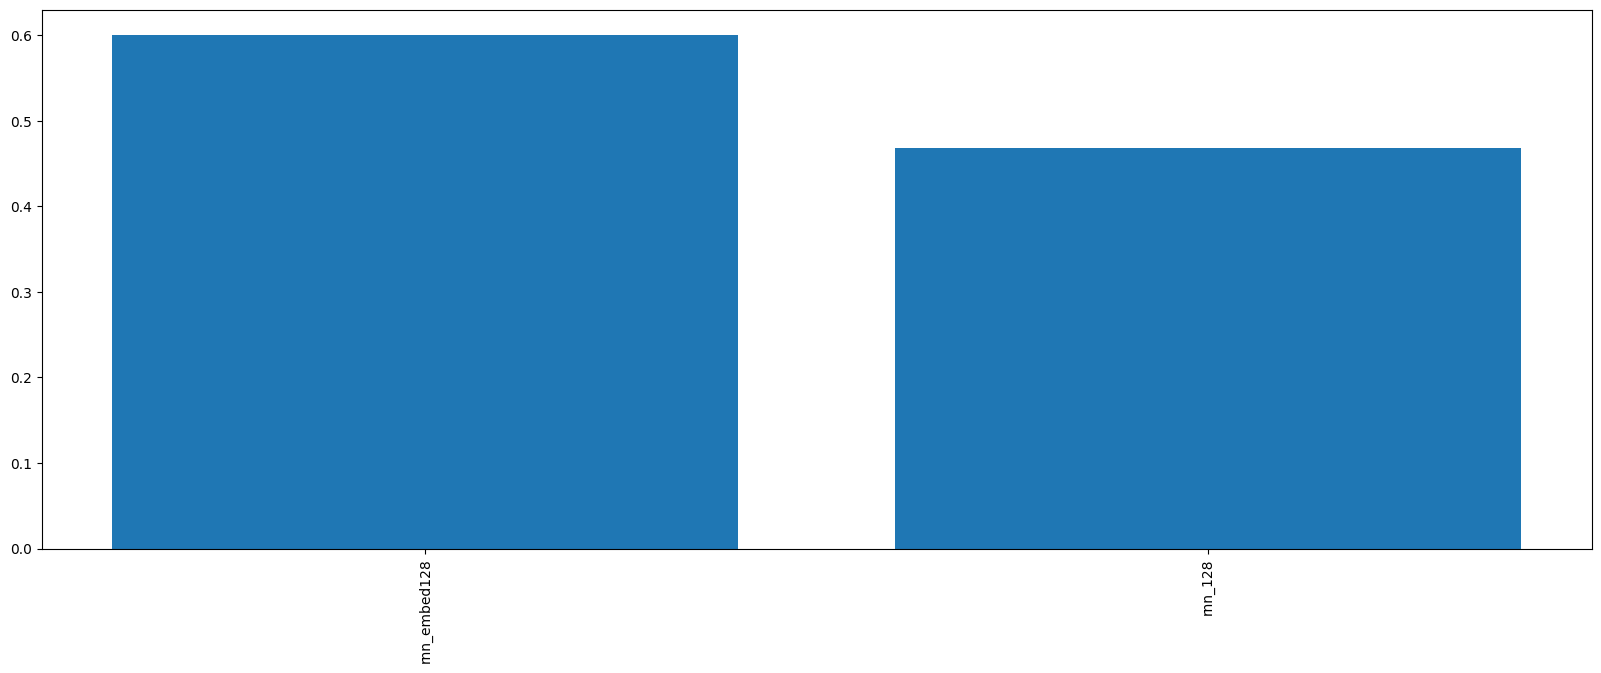

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.bar(np.array(total_list)[:,0],acc_array)
plt.xticks(rotation=90)
plt.show()

In [97]:
np.array(total_list)[:,0]

array(['rnn_embed128', 'rnn_128'], dtype='<U32')

## 6. prediction

In [ ]:
def test_model_for_category(category, num_test_samples):
    for i in range(num_test_samples):
        random_name = random.choice(category_lines[category])  # Select a random name from the category category
        name_tensor = name2tensor(random_name)
        with torch.no_grad():
            init_hidden = model_1_2.init_hidden()
            pred_tensor = torch.zeros(1, n_categories).to(device)
            for char in name_tensor.to(device):
                outputs, init_hidden = model_1_2(char.to(device), init_hidden.to(device))
            predicted_category = list(category_dict.keys())[torch.argmax(pred_tensor).item()]  # Determine the predicted category
        # Compare the predicted category with the actual category
        is_correct = predicted_category == category
        print(f"Random Name: {random_name}, Predicted Category: {predicted_category}, Correct Match: {is_correct}")

# Run the test for a specific category
num_test_samples = 10
test_category = "Greek"
test_model_for_category(test_category, num_test_samples)

In [ ]:
import random

def test_model_for_random_names(num_test_samples):
    for category in category_dict:
        print(f"Category: {category}")
        for i in range(num_test_samples):
            random_names = random.sample(category_lines[category], num_test_samples)
            for random_name in random_names:
                name_tensor = name2tensor(random_name)
                with torch.no_grad():
                    init_hidden = model_1_2.init_hidden()
                    pred_tensor = torch.zeros(1, n_categories).to(device)
                    for char in name_tensor.to(device):
                        outputs, init_hidden = model_1_2(char.to(device), init_hidden.to(device))
                    predicted_category = list(category_dict.keys())[torch.argmax(pred_tensor).item()]  # Determine the predicted category
                # Compare the predicted category with the actual category
                is_correct = predicted_category == category
                print(f"Random Name: {random_name}, Predicted Category: {predicted_category}, Correct Match: {is_correct}")

# Run the test for 1 random name from each category
num_test_samples = 1
test_model_for_random_names(num_test_samples)


In [ ]:
import random

def test_model_for_random_categories_and_names(num_selected_categories, num_names_per_category):
    selected_categories = random.sample(list(category_dict.keys()), num_selected_categories)  # Selecting 6 random categories
    for category in selected_categories:
        print(f"Category: {category}")
        random_names = random.sample(category_lines[category], num_names_per_category)  # Selecting 3 random names from the category
        for random_name in random_names:
            name_tensor = name2tensor(random_name)
            with torch.no_grad():
                init_hidden = model_1_2.init_hidden()
                pred_tensor = torch.zeros(1, n_categories).to(device)
                for char in name_tensor.to(device):
                    outputs, init_hidden = model_1_2(char.to(device), init_hidden.to(device))
                predicted_category = list(category_dict.keys())[torch.argmax(pred_tensor).item()]  # Determining the predicted category
            # Comparing the predicted category with the actual category
            is_correct = predicted_category == category
            print(f"Random Name: {random_name}, Predicted Category: {predicted_category}, Correct Match: {is_correct}")

# Running the test for 6 random categories and 3 random names from each category
num_selected_categories = 6
num_names_per_category = 3
test_model_for_random_categories_and_names(num_selected_categories, num_names_per_category)


## Padding code

In [109]:
# #import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# sequences=tokenizer.texts_to_sequences(sentences)
# padded=pad_sequences(sequences,padding="post",truncating=”post”,maxlen=8)

## 7. experiments

### 7.1. model RNN_Embed_0 (1 layer)

In [127]:
class RNN_Embed_0(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Embed_0, self).__init__()
        self.hidden_size = hidden_size
        #self.vocab_size = vocab_size
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input, hidden):
        x_argmax = torch.argmax(input,dim=0)
        embeds = self.embed(x_argmax)
        combined1 = torch.cat((embeds,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

In [118]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_0(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_0(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [124]:
def rnn_train_test_process_0(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_0(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [130]:
rnn_dict_embed_0 = model_0, optimizer_128, loss_func, epochs = rnn_train_test_process_0(has_embedding=True)
rnn_dict_embed_0


Epoch no: 1 | Train_loss: 1.87059 | Val_loss: 1.8306 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.69943 | Val_loss: 1.60486 | Val_Accuracy: 0.51
Best accuracy is : %50.83333333333333 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
# rnn_dict_embed = rnn_train_test_process_0(has_embedding=True)
# rnn_dict_embed


### 7.2. model RNN_Embed_1 (2 layer)

In [112]:
class RNN_Embed_1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Embed_1, self).__init__()
        self.hidden_size = hidden_size
        #self.vocab_size = vocab_size
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input, hidden):
        x_argmax = torch.argmax(input,dim=0)
        embeds = self.embed(x_argmax)
        combined1 = torch.cat((embeds,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

In [119]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_1(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [133]:
def rnn_train_test_process_1(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [134]:
rnn_dict_embed_1 = model_1, optimizer_128, loss_func, epochs = rnn_train_test_process_1(has_embedding=True)
rnn_dict_embed_1


Epoch no: 1 | Train_loss: 1.87755 | Val_loss: 1.76032 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.64784 | Val_loss: 1.57162 | Val_Accuracy: 0.52
Best accuracy is : %52.34375 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

### 7.3. model RNN_Embed_2 (3 layer)

In [114]:
class RNN_Embed_2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Embed_2, self).__init__()
        self.hidden_size = hidden_size
        #self.vocab_size = vocab_size
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()
        self.embed = nn.Embedding(input_size, EMBED_SIZE) #one_hot to index vector | torch.Size([1, 58]) --> torch.Size([1, 20])
        self.i2h = nn.Linear(EMBED_SIZE + hidden_size, hidden_size)
        self.i2o = nn.Linear(EMBED_SIZE + hidden_size, n_categories)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input, hidden):
        x_argmax = torch.argmax(input,dim=0)
        embeds = self.embed(x_argmax)
        combined1 = torch.cat((embeds,hidden.view(self.hidden_size)),0)

        hidden = self.i2h(combined1)
        output = self.i2o(combined1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

In [120]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_2(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_2(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [136]:
def rnn_train_test_process_2(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_2(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [137]:
model_2, optimizer_128, loss_func, epochs = rnn_train_test_process_2(has_embedding=True)


Epoch no: 1 | Train_loss: 1.8842 | Val_loss: 1.81225 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.70808 | Val_loss: 1.63476 | Val_Accuracy: 0.49
Best accuracy is : %49.47916666666667 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

###  7.5 model RNN_Embed_1_0 (128 hidden_size)

In [138]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1_0(is_embedding = False):
    hidden_size = 128
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_1(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [139]:
def rnn_train_test_process_1_0(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1_0(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [141]:
model_1_0, optimizer_128, loss_func, epochs = rnn_train_test_process_1_0(has_embedding=True)


Epoch no: 1 | Train_loss: 1.85161 | Val_loss: 1.62294 | Val_Accuracy: 0.5
Epoch no: 2 | Train_loss: 1.59804 | Val_loss: 1.55998 | Val_Accuracy: 0.53
Best accuracy is : %53.07291666666667 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

###  7.6 model RNN_Embed_1_1 (150 hidden_size)

In [ ]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1_1(is_embedding = False):
    hidden_size = 150
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_2(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [145]:
def rnn_train_test_process_1_1(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1_1(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [146]:
model_1_1, optimizer_128, loss_func, epochs = rnn_train_test_process_1_1(has_embedding=True)


Epoch no: 1 | Train_loss: 1.81439 | Val_loss: 1.6418 | Val_Accuracy: 0.5
Epoch no: 2 | Train_loss: 1.62618 | Val_loss: 1.57008 | Val_Accuracy: 0.52
Best accuracy is : %52.23958333333333 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

###  7.7 model RNN_Embed_1_2 (96 hidden_size)

In [147]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1_2(is_embedding = False):
    hidden_size = 96
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_2(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [148]:
def rnn_train_test_process_1_2(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1_2(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [149]:
model_1_2, optimizer_128, loss_func, epochs = rnn_train_test_process_1_2(has_embedding=True)


Epoch no: 1 | Train_loss: 1.9942 | Val_loss: 1.84528 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 1.84506 | Val_loss: 1.84064 | Val_Accuracy: 0.47
Best accuracy is : %46.770833333333336 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

### 7.8. model RNN_Embed_1_1_0 (SGD optimizer)

In [154]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1_1_0(is_embedding = False):
    hidden_size = 150
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_2(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [155]:
def rnn_train_test_process_1_1_0(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1_1_0(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [156]:
model_1_1_0, optimizer_128, loss_func, epochs = rnn_train_test_process_1_1_0(has_embedding=True)


Epoch no: 1 | Train_loss: 2.56353 | Val_loss: 2.25617 | Val_Accuracy: 0.47
Epoch no: 2 | Train_loss: 2.09214 | Val_loss: 1.99144 | Val_Accuracy: 0.47
Best accuracy is : %46.770833333333336 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

### 7.9. model RNN_Embed_1_1_1 (RMS optimizer)

In [157]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1_1_1(is_embedding = False):
    hidden_size = 150
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_2(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [158]:
def rnn_train_test_process_1_1_1(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1_1_1(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [159]:
model_1_1, optimizer_128, loss_func, epochs = rnn_train_test_process_1_1_1(has_embedding=True)


Epoch no: 1 | Train_loss: nan | Val_loss: nan | Val_Accuracy: 0.1
Epoch no: 2 | Train_loss: nan | Val_loss: nan | Val_Accuracy: 0.1
Best accuracy is : %10.15625 for batch_size =128


ValueError: not enough values to unpack (expected 4, got 1)

### 7.10. model RNN_Embed_1_1_2 (َAdam optimizer)

In [ ]:
# Return loss function(CrossEntropyLoss), model(customized RNN) with or without Embedding layer and optimizer function(Adam Optimizer)
def create_rnn_model_1_1_2(is_embedding = False):
    hidden_size = 150
    learning_rate = 0.001
    epochs = 2
    if is_embedding:  #Customized RNN model with Embedding layer
        model = RNN_Embed_2(n_letters,hidden_size)
    else:  #Customized RNN model with Embedding layer
        model = RNN(n_letters,hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.to(device)
    # define loss function
    loss_func = nn.CrossEntropyLoss()
    return model,optimizer,loss_func,epochs

In [ ]:
def rnn_train_test_process_1_1_2(has_embedding=False):
  batch_list = [128]
  main_accuracy_dict = {}
  for batch_i in batch_list:
    batch_size = batch_i
    model,optimizer_128,loss_func,epochs = create_rnn_model_1_1_2(has_embedding)
    train_loader,valid_loader = train_test_loader(X_train,y_train,X_test,y_test,batch_size)
    best_accuracy = 0 #best accuracy of each batch_size

    for i in range(epochs):
      # tracking time and loss
      total_train_loss = 0
      for batch in train_loader: #batch[0].size = torch.Size([128, 20, 58]) , batch[1].size = torch.Size([128])
        model.zero_grad() #reset gradients after each update
        # performing forward pass
        init_hidden = model.init_hidden()
        hidden = init_hidden.to(device)
        outputs1_tensor = torch.zeros(batch_size,n_categories).to(device)
        for idx,name in enumerate(batch[0].to(device)):
          for char in name:
            outputs1,hidden = model(char.to(device),hidden.to(device))
          outputs1_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(outputs1_tensor.to(device), batch[1].to(device))
        total_train_loss += loss.item()
        # performing a backward pass
        loss.backward()
        # update parameters
        optimizer_128.step()

      # calculate the average loss
      avg_train_loss = total_train_loss / len(train_loader)

      val_accuracy = []
      val_loss = []
      for batch in valid_loader:
        # gradients ignored for a while for testing (it speeds up computation)
        with torch.no_grad():
            init_hidden = model.init_hidden()
            pred_tensor = torch.zeros(batch_size,n_categories).to(device).to(device)
            for idx,name in enumerate(batch[0].to(device)):
              for char in name:
                outputs1,hidden = model(char.to(device),hidden.to(device))
              pred_tensor[idx] = outputs1
        # computing loss
        loss = loss_func(pred_tensor.to(device), batch[1].to(device))
        val_loss.append(loss.item())
    #Validation process
        acc = accuracy_2(pred_tensor.to(device),batch[1].to(device))
        val_accuracy.append(acc/batch_size)
      val_mean_acc = np.mean(val_accuracy)
      val_mean_loss = np.mean(val_loss)
      if val_mean_acc > best_accuracy:
          best_accuracy = val_mean_acc

      # print performance
      print(f'Epoch no: {i+1} | Train_loss: {round(avg_train_loss,5)} | Val_loss: {round(val_mean_loss,5)} | Val_Accuracy: {round(val_mean_acc,2)}')
    print(f"Best accuracy is : %{best_accuracy*100} for batch_size ={batch_size}")
    main_accuracy_dict[batch_size] = best_accuracy
  return main_accuracy_dict


In [ ]:
model_1_2, optimizer_128, loss_func, epochs = rnn_train_test_process_1_1_2(has_embedding=True)
